In [1]:
from utils import *

In [2]:
path_simus = Path('./preprocessing/')
path_index = path_simus / 'index.parquet'

In [3]:
index = pl.read_parquet(path_index)

In [4]:
percentiles = [0.99, 0.90, 0.75, 0.50, 0.25, 0.10, 0.01]

In [5]:
for params in index.iter_rows(named=True):
    params
    break
params

{'formation_length': 126,
 't_max': 10,
 'n_stocks': 100,
 'first_step': 'do_nothing',
 'window': 2,
 'third_step': 'do_nothing',
 'path_preprocessing': 'preprocessing/0.parquet'}

In [6]:
turnover = pl.col('weight').diff().over(keys[1]).abs()
ret = pl.col('weight') * pl.col('forward_return')
underwater = (pl.col('cummax') - pl.col('cumsum')) / pl.col('cummax')

metrics = [
    pl.col('turnover').mean().alias('mean_turnover'),  # independent of returns
    pl.col('return').mean().alias('raw_mean'),
    pl.col('return').std().alias('raw_std'),
    pl.col('underwater').max().alias('max_dd'),
    pl.col('underwater').mean().alias('mean_dd'),
]
annualization = [
    (pl.col('raw_mean') / 1 * 1e4).alias('roe'),
    (pl.col('raw_mean') * 252).alias('mean'),
    (pl.col('raw_std') * 252 ** .5).alias('vol'),
    ((pl.col('raw_mean') * 252) / (pl.col('raw_std') * 252 ** .5)).alias('sharpe'),
    ((pl.col('raw_mean') * 252) / pl.col('mean_dd')).alias('calmar'),
]
rot = pl.col('mean') / pl.col('mean_turnover')

# Load train weights

In [7]:
params, weights = read_data_one_preprocessing(params['path_preprocessing'], path_index)
weights = weights.select(pl.exclude('path')).collect()
weights.describe()

statistic,date,symbol,weight,path_preprocessing
str,str,str,f64,str
"""count""","""634844""","""634844""",118301.0,"""634844"""
"""null_count""","""0""","""0""",516543.0,"""0"""
"""mean""","""2009-02-13""",null,0.0,null
"""std""",null,null,0.055546,null
"""min""","""2000-08-16""","""AAL""",-0.274848,"""preprocessing/…"
"""25%""","""2005-01-06""",null,-0.018032,null
"""50%""","""2009-02-05""",null,0.001161,null
"""75%""","""2013-05-23""",null,0.019051,null
"""max""","""2017-04-20""","""ZUMZ""",0.492554,"""preprocessing/…"


# Load market data

In [8]:
market_data = (
    load_and_prepare_market_data()
    .with_columns(forward_return=pl.col('price').pct_change().shift(-1).over(keys[1]))
    .collect()
)
assert have_same_nulls(market_data, 'volume_smoothed', 'cost_transaction')

In [9]:
start_date, end_date = weights.select(pl.col('date').min().alias('min'), pl.col('date').max().alias('max')).row(0)

In [10]:
market_data = market_data.filter(pl.col('date') >= start_date).filter(pl.col('date') <= end_date + timedelta(days=3))

In [11]:
weights_n_market_data = market_data.join(weights, how='left', on=keys)
full_index = get_prod_uniques(weights_n_market_data, keys).sort(keys)
weights_n_market_data = full_index.join(weights_n_market_data, on=keys, how='left')

# Plots based on weights only

## Coverage

<Figure size 900x500 with 0 Axes>

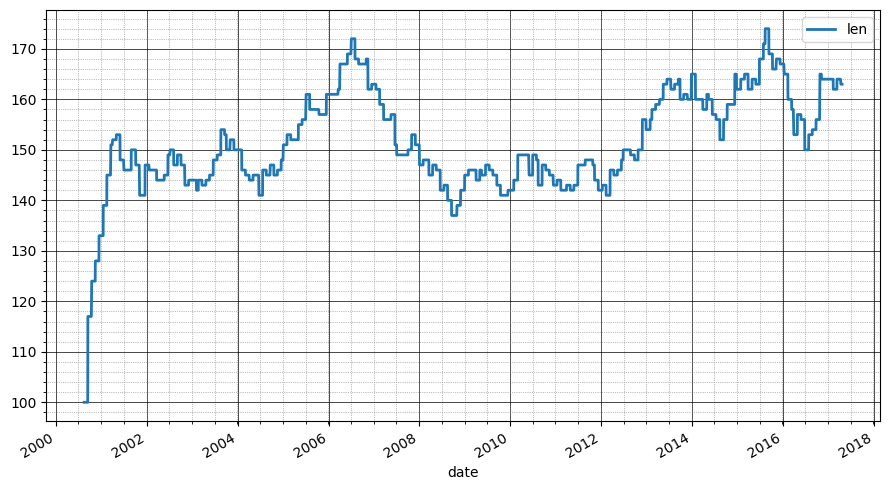

<Figure size 900x500 with 0 Axes>

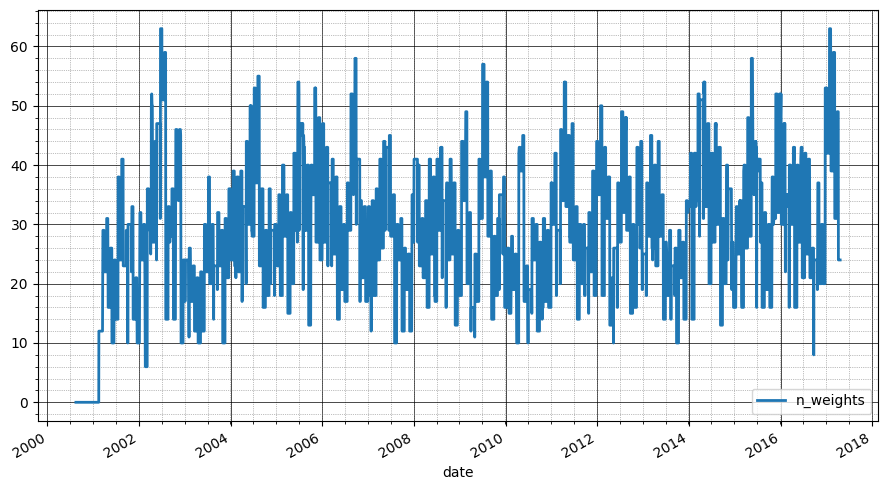

<Figure size 900x500 with 0 Axes>

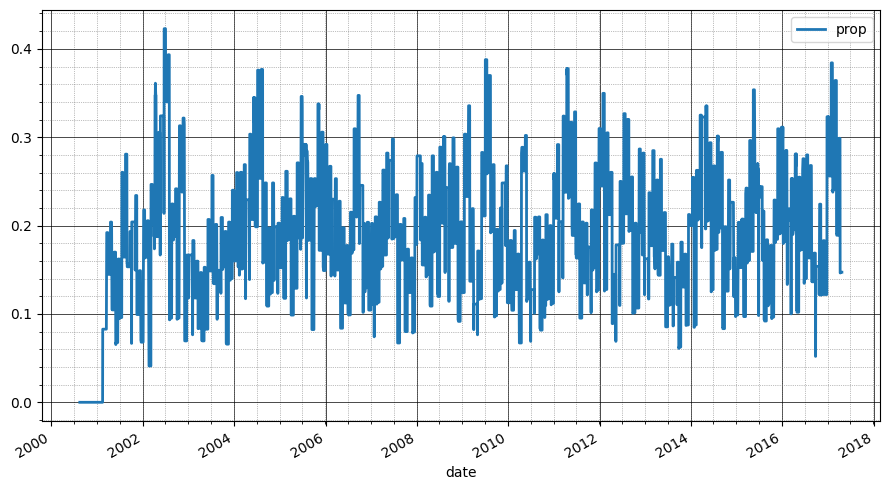

In [12]:
props = (
    weights
    .group_by('date', maintain_order=True)
    .agg([
        (pl.col('weight').is_not_null().sum() / pl.len()).alias('prop'),
        pl.col('weight').is_not_null().sum().alias('n_weights'),
        pl.len(),
    ])
)
for col in ['len', 'n_weights', 'prop']:
    plot_ts(props.select('date', col), 'date')

## Leverage

<Figure size 900x500 with 0 Axes>

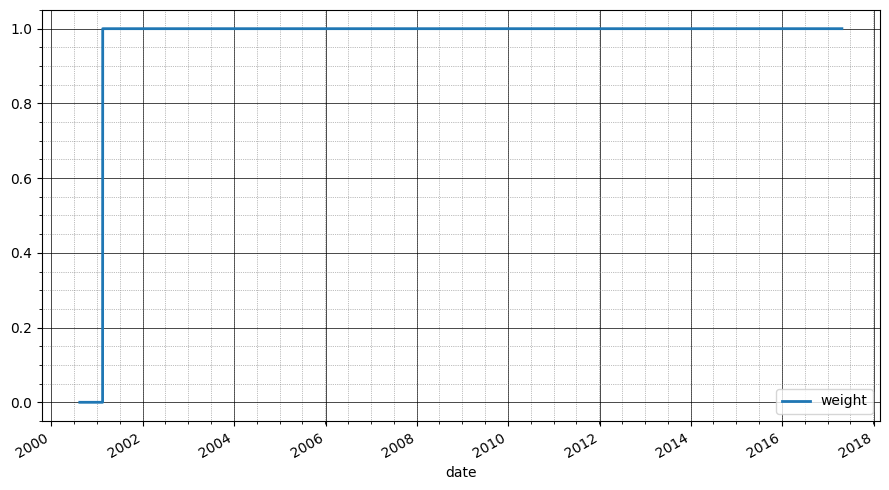

In [13]:
sub = weights.group_by(keys[0], maintain_order=True).agg(pl.col('weight').abs().sum())
plot_ts(sub.select(keys[0], 'weight'), keys[0])

## Turnover

<Figure size 900x500 with 0 Axes>

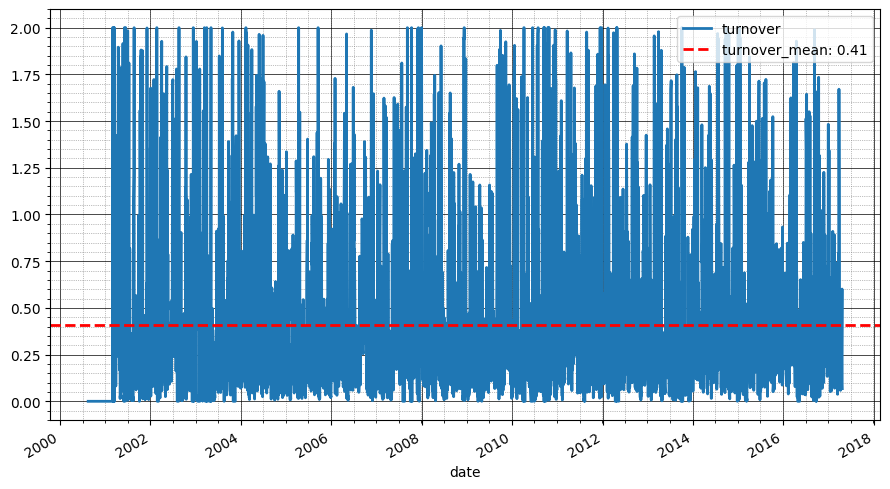

In [14]:
attrs = ['sum', 'mean', 'median', 'std']

weights_ts = (
    weights
    .with_columns(turnover=turnover)
    .group_by(keys[0], maintain_order=True)
    .agg(
        [
            getattr(pl.col('weight'), attr)().alias(f'{attr}_weight')
            for attr in attrs
        ] +
        [
            pl.col('weight').abs().sum().alias('leverage'),
            pl.col('turnover').sum(),
        ]
    )
)
plot_ts(weights_ts.select('date', 'turnover'), 'date', with_mean=True)

## Moments

<Figure size 900x500 with 0 Axes>

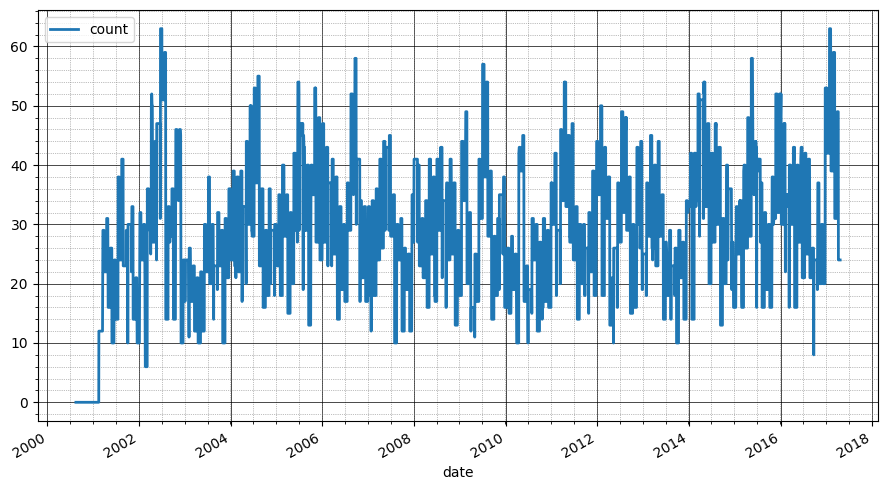

<Figure size 900x500 with 0 Axes>

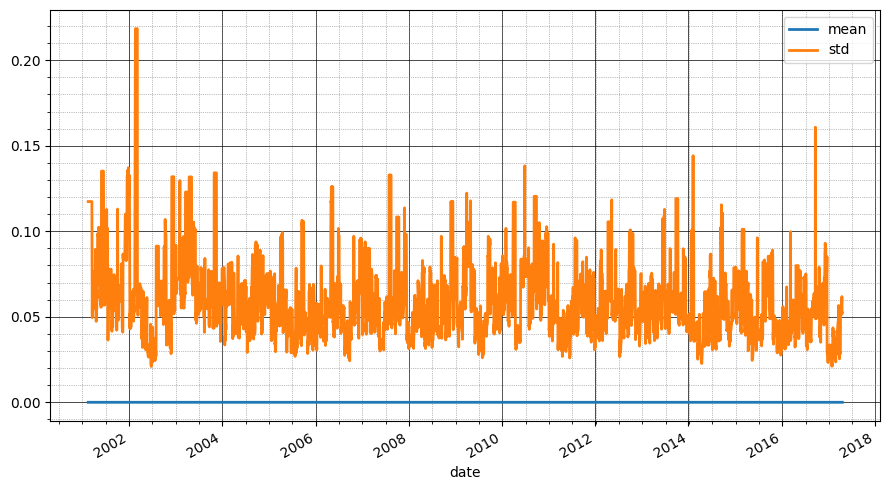

<Figure size 900x500 with 0 Axes>

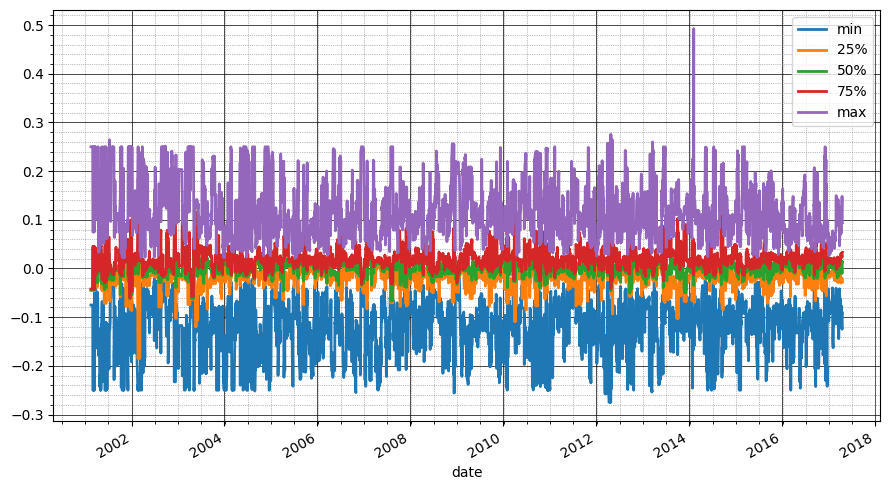

In [15]:
pivoted = pivot_to_pd(weights, *keys, 'weight')
plot_desc_pfo_matrix(pivoted)

## Autocorrelation

<Figure size 900x500 with 0 Axes>

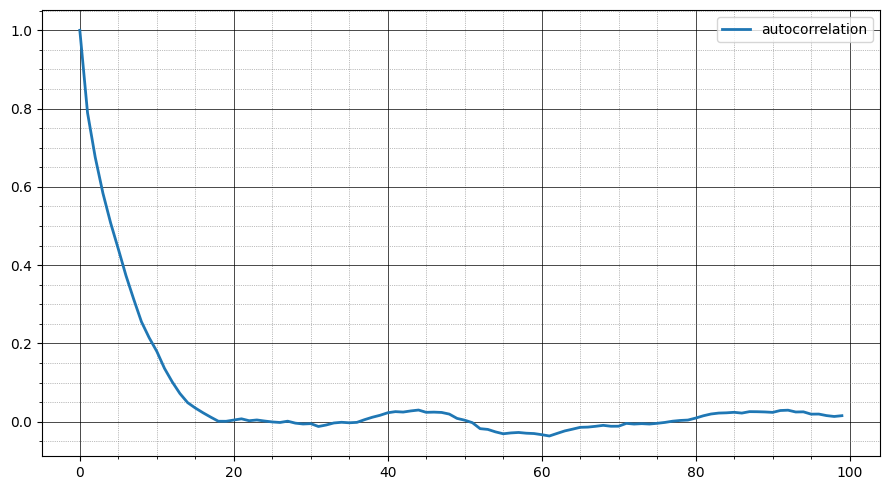

In [16]:
shifts = list(range(100))
autocorrelation = (
    weights
    .with_columns([
        pl.col('weight').shift(shift).over(keys[1]).alias(str(shift))
        for shift in shifts
    ])
    .select([
        pl.corr(str(shift), 'weight', method='spearman')
        for shift in shifts
    ])
    .to_pandas()
    .T
)
autocorrelation.index = autocorrelation.index.astype(int)
autocorrelation.columns = ['autocorrelation']
plot_pd_frame(autocorrelation)

# Plots with forward returns

## Information coefficient

<Figure size 900x500 with 0 Axes>

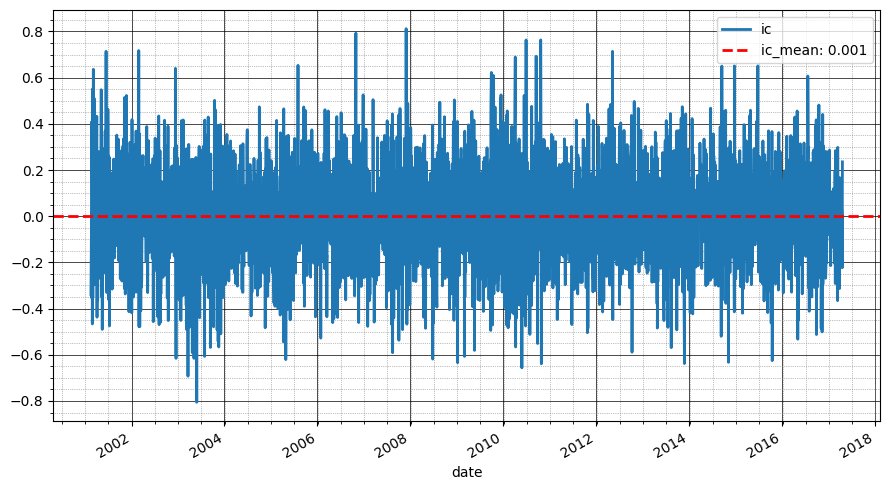

In [17]:
sub = (
    weights_n_market_data
    .group_by(keys[0], maintain_order=True)
    .agg(ic=pl.corr('weight', 'forward_return', method='spearman'))
)
plot_ts(sub.select(keys[0], 'ic'), keys[0], with_mean=True)

In [18]:
(
    weights_n_market_data
    .select(pl.corr('weight', 'forward_return', method='spearman'))
    .item()
)

0.004144043396499143

## Missing: ic decay, scatter plot (forward_return, weight)

## PnL no cost

In [19]:
cols = ['turnover', 'return', 'cumsum', 'cummax', 'underwater']
no_cost = (
   weights_n_market_data
    .with_columns(pl.col('weight').fill_null(0.0))
    .with_columns(turnover=turnover)
    .with_columns(ret.alias('return'))
    .group_by(keys[0], maintain_order=True)
    .agg(pl.col('turnover').sum(), pl.col('return').sum())
    .select(keys[0], 'turnover', 'return')
    # .with_columns(pl.col('return').fill_null(0.0))  # 'turnover' could have None
    .with_columns(cumsum=pl.col('return').cum_sum() + 1.0)
    # .with_columns(cummax=pl.col('cumsum').cum_max())
    # .with_columns(underwater=underwater)
    # .with_columns([not_finite_floats_to_none(col) for col in cols])
)
tail = no_cost.tail(20)
no_cost.null_count()

date,turnover,return,cumsum
u32,u32,u32,u32
0,0,0,0


<Figure size 900x500 with 0 Axes>

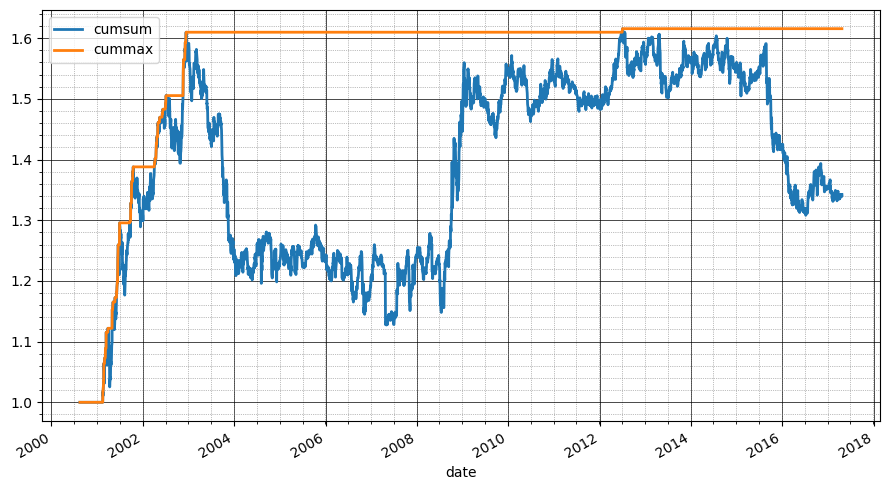

mean_turnover,max_dd,mean_dd,roe,mean,vol,sharpe,calmar,rot
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.446077,0.299606,0.114004,0.815547,0.020552,0.123782,0.166032,0.180273,0.046072


In [20]:
plot_ts(
    no_cost
    .with_columns(cummax=pl.col('cumsum').cum_max())
    .with_columns(underwater=underwater)
    .select('date', 'cumsum', 'cummax'),
    'date'
)
(
    no_cost
    .with_columns(cummax=pl.col('cumsum').cum_max())
    .with_columns(underwater=underwater)
    .select(metrics)
    .with_columns(annualization)
    .with_columns(rot=rot)
    .select(pl.exclude('raw_mean', 'raw_std'))
)

# With transaction costs

In [21]:
with_transaction_cost = (
    weights_n_market_data
    # .with_columns(cost=0.0)
    .with_columns(pl.col('weight').fill_null(0.0))
    .with_columns([
        turnover.alias('turnover'),
        ret.alias('return'),
        pl.col('price').shift(-1).over(keys[1]).alias('forward_price'),
        pl.col('weight').diff().over(keys[1]).alias('signed_turnover'),
    ])
    .group_by(keys[0], maintain_order=True)
    .agg([
        pl.col('turnover').sum(),
        pl.col('return').sum(),
        (pl.col('turnover') * pl.col('cost_transaction')).sum().alias('cost_transaction'),
    ])
    .with_columns([
        pl.col('return').cum_sum().alias('cumsum'),
        pl.col('cost_transaction').cum_sum(),
    ])
    .with_columns([
        pl.col('cumsum') - pl.col('cost_transaction') + 1.0,
    ])
    .with_columns(pl.col('cumsum').diff().alias('return_2'))
)
with_transaction_cost.tail(20).join(tail, on=keys[0])

date,turnover,return,cost_transaction,cumsum,return_2,turnover_right,return_right,cumsum_right
date,f64,f64,f64,f64,f64,f64,f64,f64
2017-03-24,1.670585,-0.002973,0.653871,0.686353,-0.003474,1.670585,-0.002973,1.340224
2017-03-27,1.697174,0.000608,0.654373,0.68646,0.000107,1.697174,0.000608,1.340832
2017-03-28,0.448344,-0.003458,0.654513,0.682861,-0.003599,0.448344,-0.003458,1.337374
2017-03-29,0.264901,-0.00201,0.654596,0.680768,-0.002093,0.264901,-0.00201,1.335364
2017-03-30,0.426365,-0.000604,0.654728,0.680032,-0.000736,0.426365,-0.000604,1.33476
2017-03-31,0.228381,0.002113,0.654798,0.682075,0.002043,0.228381,0.002113,1.336873
2017-04-03,0.2195,-0.001124,0.654865,0.680884,-0.001191,0.2195,-0.001124,1.335749
2017-04-04,0.183191,0.000957,0.654921,0.681786,0.000902,0.183191,0.000957,1.336706
2017-04-05,0.05853,-0.000563,0.654939,0.681205,-0.000581,0.05853,-0.000563,1.336144


<Figure size 900x500 with 0 Axes>

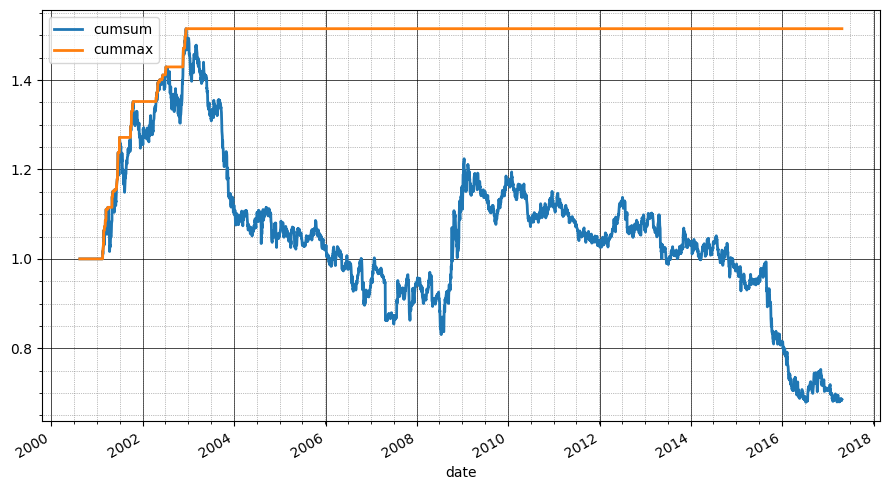

mean_turnover,max_dd,mean_dd,roe,mean,vol,sharpe,calmar,rot
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.446077,0.551644,0.281669,-0.748557,-0.018864,0.123774,-0.152404,-0.066971,-0.042288


In [22]:
plot_ts(
    with_transaction_cost
    # .with_columns(pl.col('cumsum').diff().alias('return'))
    .with_columns(cummax=pl.col('cumsum').cum_max())
    .with_columns(underwater=underwater)
    .select('date', 'cumsum', 'cummax'),
    'date'
)
(
    with_transaction_cost
    .with_columns(pl.col('cumsum').diff().alias('return'))
    .with_columns(cummax=pl.col('cumsum').cum_max())
    .with_columns(underwater=underwater)
    .select(metrics)
    .with_columns(annualization)
    .with_columns(rot=rot)
    .select(pl.exclude('raw_mean', 'raw_std'))
)